In [1]:
import pandas as pd
import sqlite3, warnings
from sqlalchemy import create_engine

warnings.filterwarnings("ignore")
engine = create_engine('sqlite:////kaggle/input/movies/movies', echo=True)
connection = engine.connect()

query1 = """ SELECT * FROM articles_data LIMIT 10 """ # we will ignore this hence just loading the first 10 rows
query2 = """ SELECT * FROM user_interactions """
art_df = pd.read_sql(query1, con=connection.connection)
user_df = pd.read_sql(query2, con=connection.connection)
display(art_df.head())
display(user_df.head())

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


## 1. Overview
### 1.1. Description
Almost in this notebook we only focus on `user_df` hence we will ignore the `art_df`

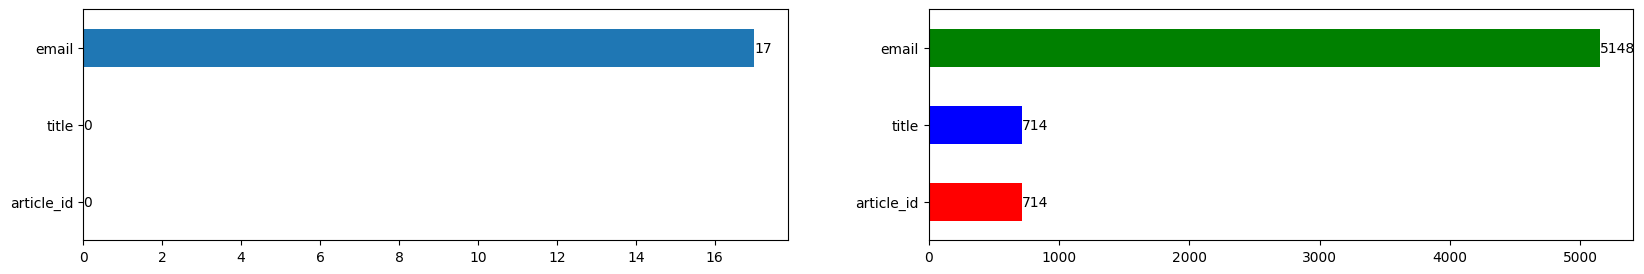

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20,3))
user_df.isnull().sum().plot(kind='barh', ax=ax[0])
user_df.nunique().plot(kind='barh', ax=ax[1], color=['r','b', 'g'])
for _ in range(2):
    for container in ax[_].containers:
        ax[_].bar_label(container)

### Define email-mapping

Now, define the `email_mapper` function was deemed a reasonable way to map users to ids. There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [3]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in user_df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
user_df['user_id'] = email_encoded
user_df.head()

,article_id,title,email,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,1
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,2
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,3
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,4
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,5


### 1.2. Verification

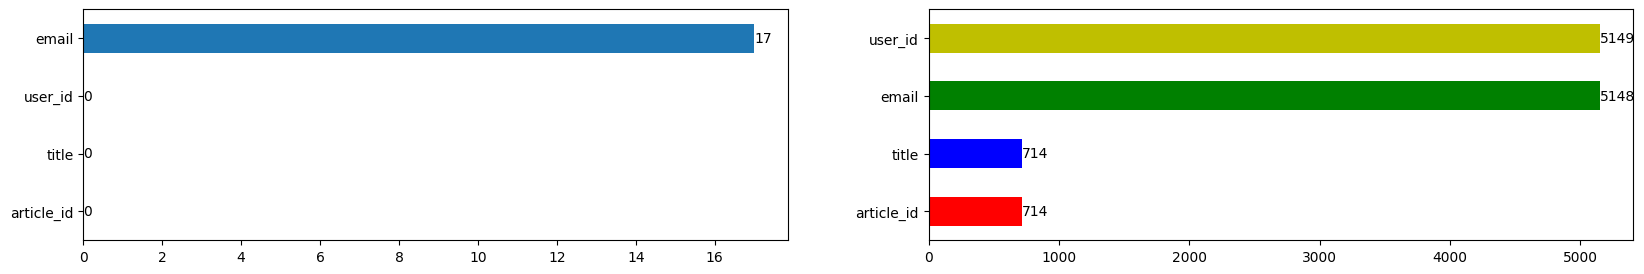

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20,3))
user_df.isnull().sum().sort_values(ascending=True).plot(kind='barh', ax=ax[0])
user_df.nunique().sort_values(ascending=True).plot(kind='barh', ax=ax[1], color=['r','b', 'g', 'y'])
for _ in range(2):
    for container in ax[_].containers:
        ax[_].bar_label(container)

### 1.3. Create the `user-article` matrix with 1's and 0's

- Each user should only appear in each row once.
- Each article should only show up in one column.
- If a user has interacted with an article, then place a 1 where the user-row meets for that article-column. It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.
- If a user has not interacted with an item, then place a zero where the user-row meets for that article-column.

In [5]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_article_idx = df.groupby(by=['user_id', 'article_id']).agg(lambda x: 1)
    user_article_mtx = user_article_idx.unstack()
    user_item = user_article_mtx.fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(user_df)
user_item.head()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
4             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                   ...  email                                            \
article_id 18.0    ... 1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                    
1             0.0  ...    0.0    0.0    1.0    0.0    1.0    0.0    0.0   
2             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0  ...    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
4             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1             0.0    0.0    0.0  
2             0.0    0.0    0.0  
3             0.0    0.0    0.0  
4             0.0    0.0    0.0  
5             0.0    0.0    0.0  

[5 rows x 1428 columns]

## 2. User-user Collaborative filtering
### 2.1. Define the function `find_similar_users`
First of all, we will check the dot-product from `numpy`

In [6]:
import numpy as np

print(np.dot(user_item.loc[1,:], user_item.loc[1,:]))
print(len(user_item.loc[1,:]))
user_item.loc[1,:].head(2)

72.0
1428


       article_id
title  0.0           0.0
       2.0           0.0
Name: 1, dtype: float64

Next, given an `user_id`, how to 

In [7]:
user_id = 2
users = user_item.index
sims = []
#=======================
for user in users:
    sims.append(np.dot(user_item.loc[user_id, :], user_item.loc[user, :]))
#=======================
dfs = pd.DataFrame({'user': users,
                   'similarity': sims
                   })
display(dfs.head())
#=======================
print(sorted(sims, reverse=True)[: 5])
dfs = dfs.sort_values(by = ['similarity', 'user'], 
                      ascending = [False, True]
                     )
display(dfs.head())

,user,similarity
0,1,4.0
1,2,12.0
2,3,2.0
3,4,6.0
4,5,0.0


[12.0, 10.0, 10.0, 10.0, 10.0]


,user,similarity
1,2,12.0
48,49,10.0
97,98,10.0
3696,3697,10.0
3763,3764,10.0


In [8]:
similarities = {}; user_id = 2
#=======================
for user in user_item.index:
    similarities[user] = np.dot(user_item.loc[user_id, :], user_item.loc[user, :])
        
list(similarities.items())[: 5]
#=======================
ordered_similarities = sorted(similarities.items(), key=lambda kv: kv[1], reverse=True)
ordered_similarities[: 5]
#=======================
most_similar_users = [key for (key, value) in ordered_similarities]
print(sorted(sims, reverse=True)[: 10])

most_similar_users.remove(user_id)
print(len(most_similar_users))

[12.0, 10.0, 10.0, 10.0, 10.0, 8.0, 8.0, 8.0, 8.0, 8.0]
5148


#### Wraping up `find_similar_users`
Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar). The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.

In [9]:
def find_similar_users(user_id, user_item = user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # initialize the similarity
    sims = []
    
    # Loop through each users
    for user in user_item.index:
        sims.append(np.dot(user_item.loc[user_id, :], user_item.loc[user, :]))

    dfs = pd.DataFrame({'user': users,
                       'similarity': sims
                       })    

    dfs = dfs.sort_values(by = ['similarity', 'user'], 
                          ascending = [False, True]
                         )
    most_similar_users = [val for val in dfs['user'].values]
    
    # Remove
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar

print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


### 2.2. Define the function to find the article-names

In [10]:
article_name = user_df[user_df['article_id'] == float(0)]['title'].values[0]
print(article_name)
#======================
user_id = 10
article_id = user_item.loc[user_id][user_item.loc[user_id]==1].title.index
article_id

detect malfunctioning iot sensors with streaming analytics


Index([ 173.0,  310.0,  585.0,  898.0,  932.0,  939.0, 1170.0, 1171.0, 1172.0,
       1174.0, 1185.0, 1305.0, 1314.0, 1330.0, 1336.0, 1360.0, 1422.0, 1427.0,
       1429.0],
      dtype='float64', name='article_id')

In [11]:
def get_article_names(article_ids, df = user_df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = [df[df['article_id'] == float(idx)]['title'].values[0] for idx in article_ids]
    
    return article_names # Return the article names associated with list of article ids

### 2.3 Define the function `get_user_articles`

In [12]:
def get_user_articles(user_id, user_item = user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = [str(idx) for idx in list(user_item.loc[user_id][user_item.loc[user_id]==1].title.index)]
    article_names = get_article_names(article_ids)  # recalled article_names from the previous function
    
    return article_ids, article_names # return the ids and names

### 2.4. Define the list of users has the most similarity with a given user

In [13]:
m = 8
most_similar_users = find_similar_users(user_id)  # recall the most_similar_users
the_user_articles, the_article_names = get_user_articles(user_id) # called the user_articles & aricle_names
# Loops through the users based on closeness to the input user_id
for user in most_similar_users:
    article_ids, article_names = get_user_articles(user)
    recs = [idx for idx in article_ids if idx not in the_user_articles]
    if len(recs) >= m:
        break    
if len(recs) < m:
    recs = [idx for idx in str(user_df['article_id']) if idx not in the_user_articles]
recs[: m]

['8.0', '16.0', '34.0', '40.0', '50.0', '53.0', '59.0', '74.0']

In [14]:
def user_user_recs(user_id, m = 10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
        Loops through the users based on closeness to the input user_id
        For each user - finds articles the user hasn't seen before and provides them as recs
        Does this until m recommendations are found

        Notes:
        Users who are the same closeness are chosen arbitrarily as the 'next' user

        For the user where the number of recommended articles starts below m 
            and ends exceeding m, the last items are chosen arbitrarily
    '''
    # Your code here
    the_most_similar_users = find_similar_users(user_id)  # recall the most_similar_users
    user_articles, article_names = get_user_articles(user_id) # called the user_articles & aricle_names
    # Loops through the users based on closeness to the input user_id
    for user in the_most_similar_users:
        article_ids, article_names = get_user_articles(user)
        recs = [idx for idx in article_ids if idx not in user_articles]
        if len(recs) >= m:
            break
    if len(recs) < m:
        recs = [idx for idx in str(df['article_id']) if idx not in the_user_articles]    
    return recs[: m] # return your recommendations for this user_id    

user_user_recs(user_id, m = 8)

['8.0', '16.0', '34.0', '40.0', '50.0', '53.0', '59.0', '74.0']

### Verification

In [15]:
for u_id, topN in [(216, 3), (1433, 2), (1, 10)]:
    print(f"{topN} recommendations for user {u_id}:\n{get_article_names(user_user_recs(u_id, topN))}\n{90*'='}")

3 recommendations for user 216:
['sector correlations shiny app', 'shaping data with ibm data refinery', 'score a predictive model built with ibm spss modeler, wml & dsx']
2 recommendations for user 1433:
['this week in data science (april 18, 2017)', 'timeseries data analysis of iot events by using jupyter notebook']
10 recommendations for user 1:
['this week in data science (april 18, 2017)', 'timeseries data analysis of iot events by using jupyter notebook', 'got zip code data? prep it for analytics. – ibm watson data lab – medium', 'higher-order logistic regression for large datasets', 'using machine learning to predict parking difficulty', 'deep forest: towards an alternative to deep neural networks', 'experience iot with coursera', 'using brunel in ipython/jupyter notebooks', 'graph-based machine learning', 'the 3 kinds of context: machine learning and the art of the frame']


### 2.5. How to find the top items (article / article_id ) and top users
#### 2.5.1. `get_top_sorted_users`
First of all, we will have a following demo

In [16]:
neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity', 'num_interactions'])
# Loop through each user by row
for user in user_item.index:    
    # continue if map the id
    if user == user_id:
        continue    
    # insert to each row the values of each column by .loc attribute
    neighbors_df.loc[user, 'neighbor_id'] = user  # neighbor user_id
    neighbors_df.loc[user, 'similarity'] = np.dot(user_item.loc[user_id, :], user_item.loc[user, :]) # similarity
    neighbors_df.loc[user, 'num_interactions'] = user_df[user_df['user_id'] == user]['article_id'].count() # the number of articles viewed by the user
                             
neighbors_df.sort_values(by = ['similarity', 'num_interactions'], 
                         ascending = [False, True], 
                         inplace = True)
neighbors_df.head()

,neighbor_id,similarity,num_interactions
3354,3354,34.0,20
3697,3697,30.0,145
49,49,30.0,147
3764,3764,28.0,169
98,98,28.0,170


#### Wraping up

In [17]:
def get_top_sorted_users(user_id, df=user_df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    users = []
    sims = []
    nb_intact = []
    for user in user_item.index:
        if user == user_id:
            continue
        users.append(user)  
        sims.append(np.dot(user_item.loc[user_id, :], user_item.loc[user, :])) 
        nb_intact.append(df[df['user_id'] == user]['article_id'].count())
    neighbors_df = pd.DataFrame({'neighbor_id': users, 
                                 'similarity': sims, 
                                 'num_interactions': nb_intact})
    
    neighbors_df.sort_values(by = ['similarity', 'num_interactions'], 
                             ascending = [False, True], 
                             inplace = True)

    return neighbors_df

print(f"user.id: {user_id}")
get_top_sorted_users(user_id).head(10)

user.id: 10


,neighbor_id,similarity,num_interactions
3352,3354,34.0,20
3695,3697,30.0,145
47,49,30.0,147
3762,3764,28.0,169
96,98,28.0,170
3620,3622,26.0,83
320,322,26.0,85
3780,3782,24.0,363
21,23,24.0,364
3594,3596,22.0,131


#### Next is `get_top_articles` and `get_top_article_ids`

In [18]:
def get_top_articles(n, df=user_df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    draft = df.groupby(by='title').count().sort_values(by='user_id', ascending=False)
    top_articles = list(draft.head(n).index)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=user_df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    draft = df.groupby(by='article_id').count().sort_values(by='user_id', ascending=False)
    top_articles = list(draft.head(n).index)
    
    return top_articles # Return the top article ids

Now we are going to improve the consistency of the `user_user_recs` function from above.

- Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.

- Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the `top_articles` function you wrote earlier.

#### 2.5.3. `user_user_recs_part2`: version 2 of `user-user-recs`
Again, look at the following scripts and its output before wrapping it in the next step

In [19]:
# create a dataframe of 'neighbor_id', 'similarity', 'num_interactions'
neighbors_df = get_top_sorted_users(user_id)

# recall the user-article & article-name from user-id
the_user_articles, the_article_names = get_user_articles(user_id)

# Loop through each user in the neighbor_id from the neighbor_df
for user in neighbors_df['neighbor_id']:

    # get the id and name of article from the user
    article_ids, article_names = get_user_articles(user)
            
    # # Loop through each id in article, if index is not in the user-articles, attached it to the recommendation
    recs = [idx for idx in article_ids if idx not in the_user_articles] 
    
    # if number of recomnendation is greater than the number of recommendations you want for the user; break
    if len(recs) >= m:
        break

# if not
idx_str = [str(id) for id in get_top_article_ids(100)]
if len(recs) < m:

    # Loop through each index
    recs = [idx for idx in idx_str if idx not in the_user_articles]

rec_names = get_article_names(recs)
rec_names[: m]

['data science bowl 2017',
 'higher-order logistic regression for large datasets',
 'top 10 machine learning use cases: part 1',
 'ensemble learning to improve machine learning results',
 'graph-based machine learning',
 'introducing streams designer',
 '20405    how to tame the valley — hessian-free hacks fo...\nName: title, dtype: object',
 'the 3 kinds of context: machine learning and the art of the frame']

#### Wraping up

In [20]:
def user_user_recs_part2(user_id, m = 10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    neighbors_df = get_top_sorted_users(user_id)
    user_articles, article_names = get_user_articles(user_id)
    for user in neighbors_df['neighbor_id']:
        article_ids, article_names = get_user_articles(user)
        recs = [idx for idx in article_ids if idx not in user_articles] 
        if len(recs) >= m:
            break
    idx_str = [str(id) for id in get_top_article_ids(100)]
    if len(recs) < m:
        recs = [idx for idx in idx_str if idx not in user_articles]
    rec_names = get_article_names(recs)[: m]
    
    return recs, rec_names

for user_id, topN in [(10, 2), (1, 3), (20, 10), (16, 5), (1221, 3)]:
    rec_ids, rec_names = user_user_recs_part2(user_id, topN)
    print(f"The top {topN} recommendations for user {user_id} are the following article ids:\n{rec_ids[:topN]}\n{80*'-'}")
    print(f"The top {topN} recommendations for user {user_id} are the following article names:\n{rec_names}\n")
    print(80*'=')

The top 2 recommendations for user 10 are the following article ids:
['8.0', '16.0']
--------------------------------------------------------------------------------
The top 2 recommendations for user 10 are the following article names:
['data science bowl 2017', 'higher-order logistic regression for large datasets']

The top 3 recommendations for user 1 are the following article ids:
['2.0', '12.0', '14.0']
--------------------------------------------------------------------------------
The top 3 recommendations for user 1 are the following article names:
['this week in data science (april 18, 2017)', 'timeseries data analysis of iot events by using jupyter notebook', 'got zip code data? prep it for analytics. – ibm watson data lab – medium']

The top 10 recommendations for user 20 are the following article ids:
['110.0', '1059.0', '1163.0', '1314.0', '1330.0', '1351.0', '1360.0', '1396.0', '1433.0', '1436.0']
---------------------------------------------------------------------------

#### Verification

In [21]:
for user_id, rank in [(10, 1), (1, 1), (131, 10), (174, 30), (1137, 2), (1433, 3)]:
    if rank == 1:
        str_rank = '1st'
    elif rank == 2:
        str_rank = '2nd'
    elif rank == 3:
        str_rank = '3rd'
    else:
        str_rank = f"{rank}-th"
        
    print(f"the {str_rank} most similar user to user {user_id} is: \t {get_top_sorted_users(user_id)['neighbor_id'].values[rank-1]}")

the 1st most similar user to user 10 is: 	 3354
the 1st most similar user to user 1 is: 	 3933
the 10-th most similar user to user 131 is: 	 3910
the 30-th most similar user to user 174 is: 	 5139
the 2nd most similar user to user 1137 is: 	 3764
the 3rd most similar user to user 1433 is: 	 3782


#### Discussion?
If we were given a new user, which of the above functions would you be able to use to make recommendations? 

In [22]:
new_user = '0.0'
print(get_top_article_ids(10))
# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(idx) for idx in get_top_article_ids(10)]
print(set(new_user_recs))

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]
{'1304.0', '1431.0', '1293.0', '1170.0', '1364.0', '1162.0', '1429.0', '1314.0', '1427.0', '1330.0'}
